In [2]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [3]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [4]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), mismatched flags (14))


In [5]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [7]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [8]:
c_args = Args(use_cuda = false)
g_args = Args(use_cuda = true)

Args(0.0003, 256, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

# Static

In [9]:
x_in = random_symbols((1024, 64), c_args.rng)

1024×64 Matrix{Float64}:
 -0.0910342  -0.129674    0.77936   …  -0.532569  -0.913493   -0.0674055
 -0.652851    0.191225    0.636154     -0.690423  -0.651747    0.783783
  0.322372   -0.502117   -0.846143      0.71537    0.98589     0.335239
 -0.356677    0.97955     0.609569      0.69781   -0.0805242   0.113233
  0.339179   -0.256667   -0.497257      0.468477   0.920877   -0.753214
 -0.482829   -0.492278   -0.331472  …  -0.147469  -0.850213    0.386855
 -0.722966    0.449293    0.369529      0.544685  -0.389939    0.166327
 -0.667123    0.835041    0.884099      0.923195  -0.943986   -0.668097
 -0.93212     0.965087   -0.805699      0.703378   0.681558    0.0390562
  0.0540299   0.977571   -0.797641      0.388623   0.156528    0.86031
  0.0470675   0.941446   -0.567839  …  -0.17208   -0.0493051   0.636357
 -0.0339558   0.459407   -0.408731      0.284862  -0.792269    0.284602
  0.74201     0.0566059   0.726023      0.302677  -0.977437    0.392515
  ⋮                                 ⋱ 

In [10]:
layer = Chain(PhasorDense(1024 => 16),)

Chain(
    layer_1 = PhasorDense((1024, 16)),  # 16_416 parameters
)         # Total: 16_416 parameters,
          #        plus 0 states.

In [11]:
sol_layer = Chain(PhasorDense(1024 => 16, return_solution=true),)

Chain(
    layer_1 = PhasorDense((1024, 16)),  # 16_416 parameters
)         # Total: 16_416 parameters,
          #        plus 0 states.

In [12]:
ps, st = Lux.setup(c_args.rng, layer)

((layer_1 = (weight = Float32[0.037095554 -0.0036778199 … -0.0082488675 0.038745463; -0.007943146 0.0029796099 … -0.06607573 0.030541673; … ; 0.04128604 -0.015050093 … -0.03936478 0.03630052; -0.01596301 0.08777253 … 0.053819522 0.061433077], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),), (layer_1 = NamedTuple(),))

In [13]:
function zero_weights(nt::NamedTuple)
    return NamedTuple{keys(nt)}(map(zero_weights, values(nt)))
end

function zero_weights(x::AbstractArray)
    return x
end

function zero_weights(x)
    return x
end

function zero_weights(nt::NamedTuple{(:bias_real,)})
    return (bias_real = zeros(size(nt.bias_real)),)
end

function zero_weights(nt::NamedTuple{(:bias_imag,)})
    return (bias_imag = zeros(size(nt.bias_imag)),)
end

function zero_weights(nt::NamedTuple{names}) where names
    new_nt = nt
    if :bias_real in names
        new_nt = merge(new_nt, (bias_real = zeros(size(nt.bias_real)),))
    end
    if :bias_imag in names
        new_nt = merge(new_nt, (bias_imag = zeros(size(nt.bias_imag)),))
    end
    if new_nt === nt
        return NamedTuple{names}(map(zero_weights, values(nt)))
    else
        return new_nt
    end
end


zero_weights (generic function with 5 methods)

In [14]:
ps_nb = zero_weights(ps)

(layer_1 = (weight = Float32[0.037095554 -0.0036778199 … -0.0082488675 0.038745463; -0.007943146 0.0029796099 … -0.06607573 0.030541673; … ; 0.04128604 -0.015050093 … -0.03936478 0.03630052; -0.01596301 0.08777253 … 0.053819522 0.061433077], bias_real = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], bias_imag = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),)

In [15]:
y, _ = layer(x_in, ps, st)

([0.09356480429882466 0.15459394361034487 … 0.006036226520473498 0.23047749610866639; -0.2483115962365225 0.4567432518750994 … 0.2377990533067953 -0.05347959455973291; … ; 0.023376408135157456 -0.58213113971723 … 0.01673447604935443 -0.7973031129382445; 0.348972388842076 0.04689254546312019 … -0.2465467666867272 0.39910019922313084], (layer_1 = NamedTuple(),))

In [16]:
yu, _ = layer(x_in, ps_nb, st)

([0.2825089285668013 0.2186362211533634 … 0.018302921664276793 0.6444355969234894; -0.41833028210287143 0.8089398670533445 … 0.6444146163518726 -0.10319269414206052; … ; 0.03842293117743715 -0.9144562224387787 … 0.03344607520122641 -0.9264977924805946; 0.5944970700919281 0.0783685193965949 … -0.3962353148584692 0.7369624361648943], (layer_1 = NamedTuple(),))

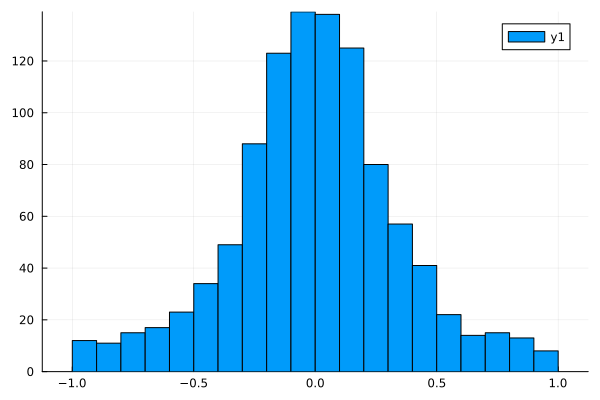

In [17]:
histogram(vec(y))

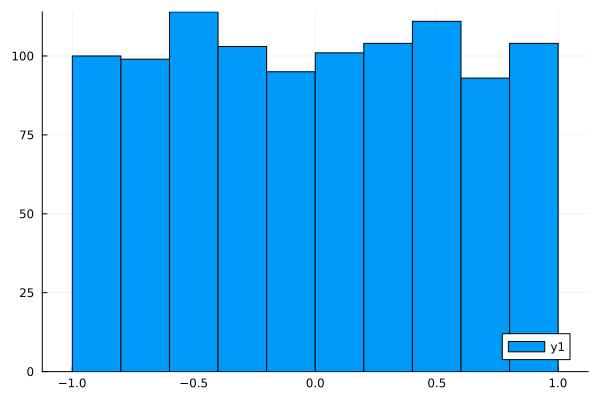

In [18]:
histogram(vec(yu))

In [19]:
ps_g = gdev(ps)
st_g = gdev(st)
ps_gu = gdev(ps_nb)
x_in_g = gdev(x_in);

In [20]:
y_g, _ = layer(x_in_g, ps_g, st_g)

(Float32[0.09356485 0.15459396 … 0.0060362443 0.23047751; -0.2483116 0.4567433 … 0.23779905 -0.05347958; … ; 0.023376407 -0.5821309 … 0.016734468 -0.79730314; 0.3489724 0.046892542 … -0.24654679 0.3991003], (layer_1 = NamedTuple(),))

In [21]:
y_gu, _ = layer(x_in_g, ps_gu, st_g)

(Float32[0.28250903 0.21863624 … 0.018302979 0.6444355; -0.41833028 0.80893993 … 0.6444146 -0.10319268; … ; 0.03842293 -0.9144562 … 0.033446055 -0.9264978; 0.5944971 0.078368515 … -0.39623535 0.73696244], (layer_1 = NamedTuple(),))

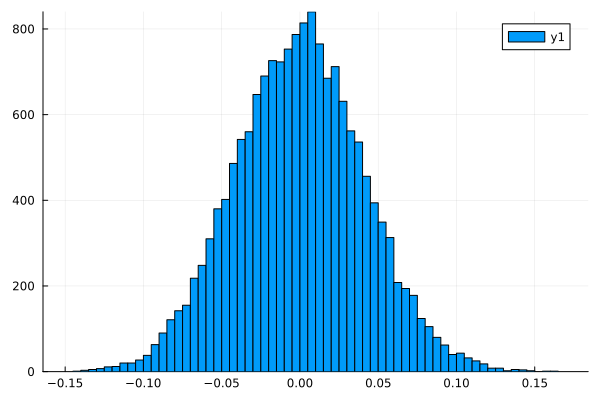

In [22]:
histogram(vec(ps.layer_1.weight))

In [23]:
y2 = y_g |> cdev
y2u = y_gu |> cdev

16×64 Matrix{Float32}:
  0.282509    0.218636   -0.0529402  …   0.685744    0.018303     0.644436
 -0.41833     0.80894     0.0993802     -0.396955    0.644415    -0.103193
  0.170338    0.111812    0.651589       0.541687    0.0692996    0.423317
  0.812106    0.315461   -0.0551338     -0.219486   -0.422408     0.404127
 -0.426127   -0.560646   -0.372523      -0.644022    0.120729    -0.116522
 -0.632052    0.442394   -0.26978    …  -0.335546   -0.606178    -0.720804
  0.710316    0.656216   -0.69006       -0.909583    0.0161163   -0.393719
  0.869429    0.807713    0.30404       -0.248691   -0.0386998    0.172449
 -0.224066   -0.268088    0.447981      -0.472441   -0.00585682  -0.318414
  0.696156    0.706575   -0.661516      -0.518075    0.867882     0.109799
  0.70208    -0.873212   -0.462797   …  -0.427835    0.424808     0.891757
 -0.978313    0.756769    0.417098      -0.22989    -0.505147     0.539676
 -0.58175     0.568417   -0.361152       0.846059   -0.520499     0.902408
 -

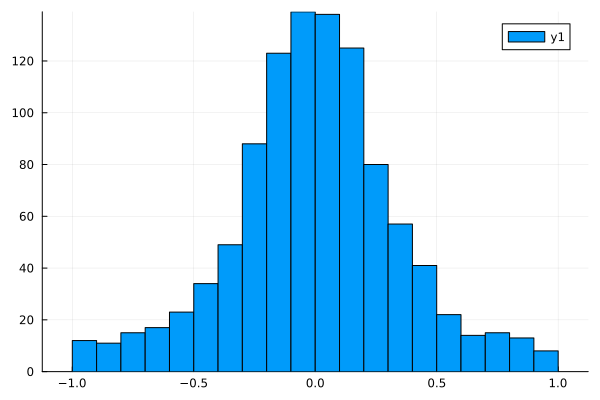

In [24]:
histogram(vec(y2))

In [25]:
maximum(y .- y2)

8.190519490969272e-7

In [26]:
maximum(yu .- y2u)

5.380150488454305e-7

# Dynamic

In [53]:
st_x = phase_to_train(x_in, spk_args=spk_args, repeats=10)

Spike Train: (1024, 64) with 655360 spikes.

In [54]:
st_xg = SpikeTrainGPU(st_x)

SpikeTrainGPU(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1015, 64), CartesianIndex(1016, 64), CartesianIndex(1017, 64), CartesianIndex(1018, 64), CartesianIndex(1019, 64), CartesianIndex(1020, 64), CartesianIndex(1021, 64), CartesianIndex(1022, 64), CartesianIndex(1023, 64), CartesianIndex(1024, 64)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  65527, 65528, 65529, 65530, 65531, 65532, 65533, 65534, 65535, 65536], Float32[0.4544829, 0.17357457, 0.6611862, 0.3216616, 0.66958964, 0.25858545, 0.1385169, 0.16643864, 0.033940017, 0.527015  …  9.333739, 9.998009, 9.716048, 9.849847, 9.528879, 9.623125, 9.593719, 9.531739, 9.085892, 9.116451], (1024, 64), 65536, 0.0f0)

In [55]:
y_t, _ = layer(SpikingCall(st_x, spk_args, (0.0, 10.0)), ps, st)

(SpikingCall(Spike Train: (16, 64) with 10240 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(),))

In [56]:
y_sol, _ = sol_layer(SpikingCall(st_x, spk_args, (0.0, 10.0)), ps, st)

(ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, Nothing, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dzdt#121"{SpikingArgs, SpikeTrain, Matrix{Float32}, Vector{ComplexF32}, Main.PhasorNetworks.var"#27#28"{Float32, Float32}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, OrdinaryDiffEqCore.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dzdt#121"{SpikingArgs, SpikeTrain, Matrix{Float32}, Vector{ComplexF32},

In [57]:
y_tu, _ = layer(SpikingCall(st_x, spk_args, (0.0, 10.0)), ps_nb, st);

In [58]:
u = y_sol.(tbase) |> stack;

In [59]:
size(u)

(16, 64, 1001)

In [60]:
u_p = potential_to_phase(u, tbase, spk_args=spk_args)

16×64×1001 Array{Float64, 3}:
[:, :, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0     -1.0  -1.0  -1.0  

In [61]:
y[1,1]

0.09356480429882466

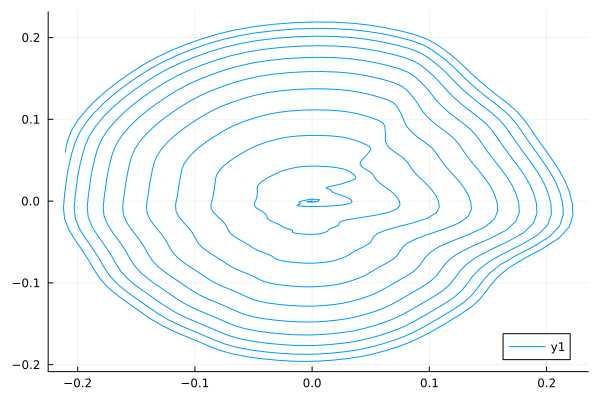

In [62]:
plot(real.(u[1,1,:]), imag.(u[1,1,:]))

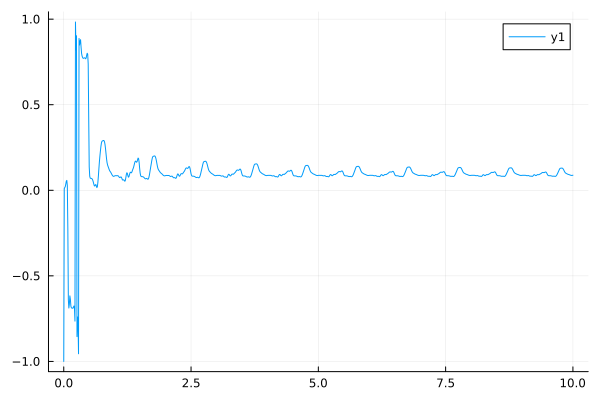

In [63]:
plot(tbase, u_p[1,1,:])

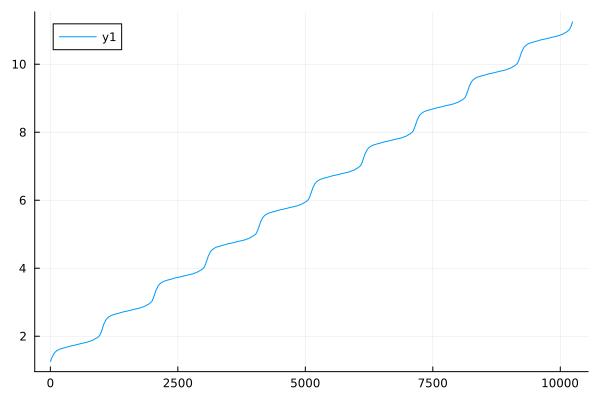

In [64]:
plot(sort(y_t.train.times))

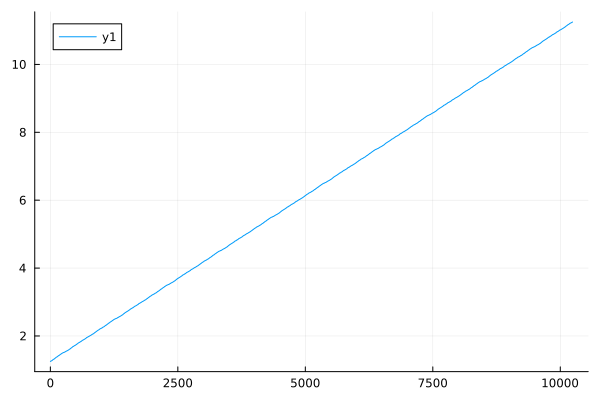

In [65]:
plot(sort(y_tu.train.times))

In [66]:
y_tp = train_to_phase(y_t);

In [67]:
y_tpu = train_to_phase(y_tu);

In [68]:
spk_args.spk_scale

1.0f0

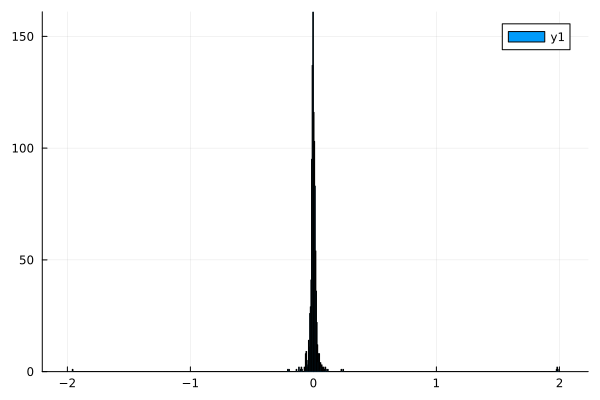

In [69]:
histogram(vec(y_tpu[5,:,:] .- yu))

In [70]:
y_tg, _ = layer(SpikingCall(st_xg, spk_args, (0.0, 10.0)), ps_g, st_g)

(SpikingCall(SpikeTrainGPU(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(7, 64), CartesianIndex(8, 64), CartesianIndex(9, 64), CartesianIndex(10, 64), CartesianIndex(11, 64), CartesianIndex(12, 64), CartesianIndex(13, 64), CartesianIndex(14, 64), CartesianIndex(15, 64), CartesianIndex(16, 64)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024], Float32[1.7920957, 1.6286341, 1.8041304, 1.8482543, 1.6060398, 1.6265956, 2.0197718, 2.0178847, 1.6908517, 2.0078938  …  10.660003, 10.789351, 10.709717, 10.777481, 11.122454, 10.813728, 10.779368, 10.858105, 10.332255, 10.941636], (16, 64), 1024, 0.25f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(),))

In [71]:
y_tgu, _ = layer(SpikingCall(st_xg, spk_args, (0.0, 10.0)), ps_gu, st);

In [72]:
y_tpg = train_to_phase(y_tg);

In [73]:
y_tpgu = train_to_phase(y_tgu);

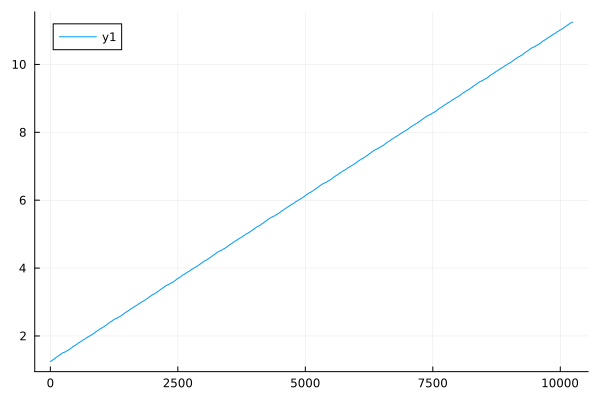

In [74]:
plot(sort(y_tgu.train.times |> cdev))

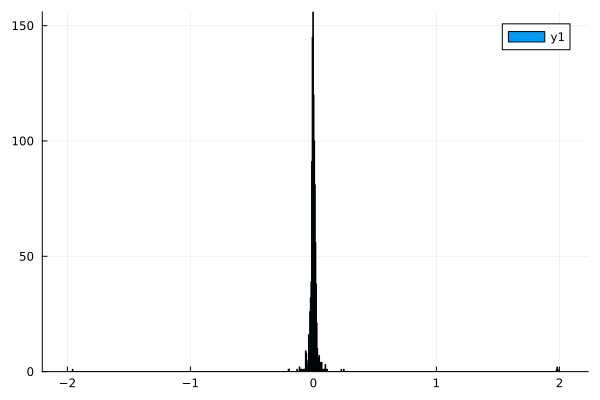

In [75]:
histogram(vec(y_tpgu[5,:,:] .- yu))

In [76]:
abs(0.0 + 1.0im)

1.0

In [77]:
typeof(y_tpg)

Array{Float64, 3}

In [78]:
size(y_tp)

(10, 16, 64)

In [79]:
size(y_tpg)

(11, 16, 64)

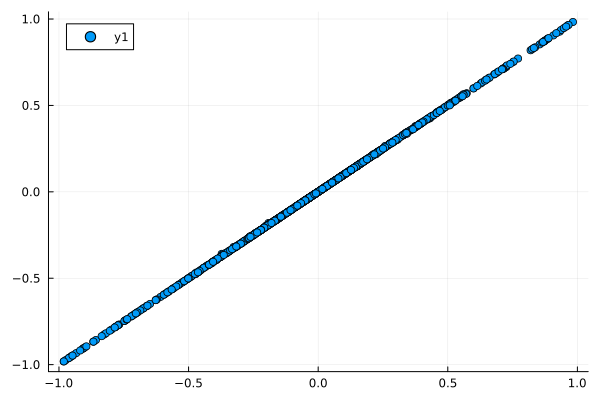

In [80]:
scatter(vec(y_tp[4,:,:]), vec(y_tpg[4,:,:]))

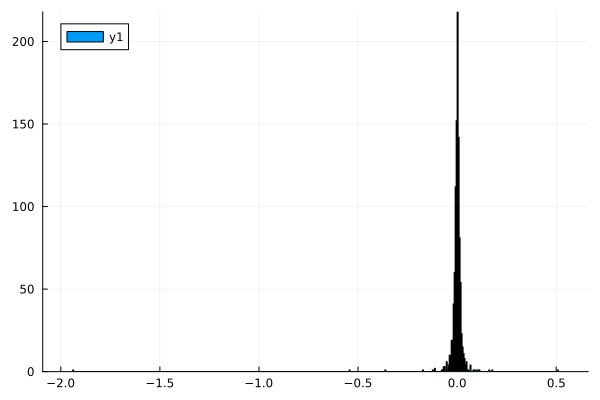

In [81]:
histogram(vec(y .- y_tpg[8,:,:]))

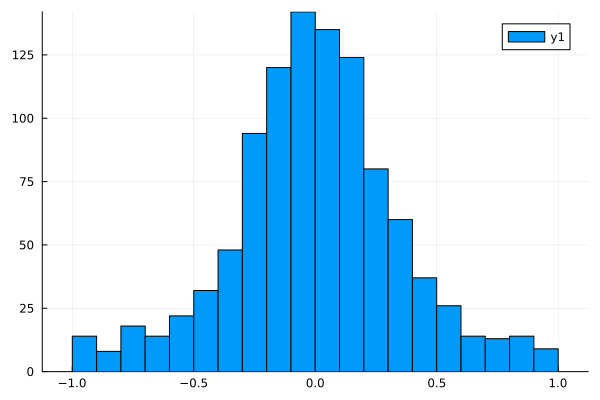

In [82]:
histogram(y_tpg[8,:,:] |> vec)

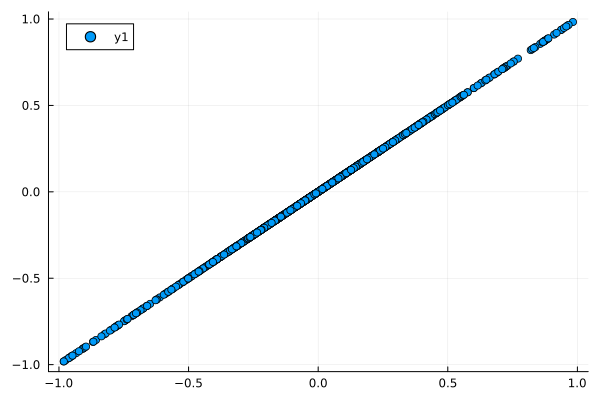

In [83]:
scatter(vec(y_tp[8,:,:]), vec(y_tpg[8,:,:]))

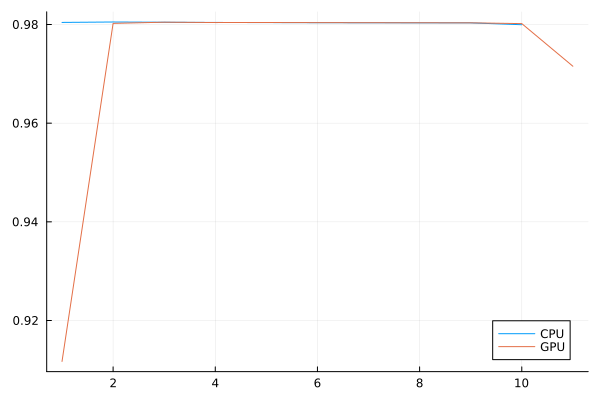

In [84]:
plot(cycle_correlation(y, y_tp), label = "CPU")
plot!(cycle_correlation(y, y_tpg), label="GPU")